In [1]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import keras
import keras.layers as layers
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold, train_test_split
from sklearn.metrics import confusion_matrix

2024-05-25 20:44:41.549183: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 20:44:42.063173: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
DataSolarModules = pd.read_json('InfraredSolarModules/module_metadata.json').transpose().sort_index()
DataSolarModulesGT = pd.read_json('InfraredSolarModules/GT_metadata.json').transpose().sort_index()
Classes = DataSolarModules['anomaly_class'].unique()
class_to_number = dict(enumerate(Classes.flatten(), 0))
class_to_number = {v: k for k, v in class_to_number.items()}

In [3]:
def map_to_class(value):
    class_to_number
    return class_to_number.get(value, 'Unknown')

DataSolarModules['class_code'] = DataSolarModules['anomaly_class'].apply(map_to_class)
DataSolarModulesGT['class_code'] = DataSolarModulesGT['anomaly_class'].apply(map_to_class)

In [4]:
def read_images_dataframe(dataframe):
    images = []
    for image_path in dataframe['image_filepath']:
        img = cv2.imread("InfraredSolarModules/"+image_path,cv2.IMREAD_GRAYSCALE)
        img = img.reshape(40, 24).astype("float32") / 255
        images.append(img)
    images=np.array(images) 
    return images

def read_labels_dataframe(dataframe):
    labels = []
    for label in dataframe['class_code']:
        labels.append(label)
    labels=np.array(labels) 
    labels.astype("int32")   
    return labels

In [5]:
images_OG = read_images_dataframe(DataSolarModules)
images_GT = read_images_dataframe(DataSolarModulesGT)
labels_OG = read_labels_dataframe(DataSolarModules)
labels_GT = read_labels_dataframe(DataSolarModulesGT)

images=np.concatenate((images_OG, images_GT), axis=0)
labels=np.concatenate((labels_OG, labels_GT), axis=0)

In [6]:
# Create a testing set with 25 images per class
num_images_per_class = 40

def create_testing_set(dataframe, num_images_per_class):
    test_indices = []
    for cls in dataframe['class_code'].unique():
        class_indices = dataframe[dataframe['class_code'] == cls].index[:num_images_per_class].tolist()
        test_indices.extend(class_indices)
    return test_indices

test_indices = create_testing_set(DataSolarModules, num_images_per_class)
data_test = np.array(test_indices)

# Create a training set with the remaining images
data_train = np.setdiff1d(np.arange(len(images)), data_test)

In [7]:
inputs = keras.Input(shape=(40, 24, 1))


x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)

x = layers.Flatten()(x)

x = layers.Dense(2048, activation="relu")(x)
x = layers.Dropout(0.4, noise_shape=None, seed=None)(x)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.4, noise_shape=None, seed=None)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.4, noise_shape=None, seed=None)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.4, noise_shape=None, seed=None)(x)
x = layers.Dense(128, activation="relu")(x)


outputs = layers.Dense(12, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

2024-05-25 20:44:56.708452: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-25 20:44:56.739210: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-25 20:44:56.739431: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 40, 24, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 38, 22, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 11, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 9, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 2, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,386,956 (16.73 MB)

 Trainable params: 4,386,956 (16.73 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
batch_size = 64
n_epochs = 25

optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)

rkf = RepeatedKFold(n_splits=6, n_repeats=3, random_state=21312312)


model.compile(optimizer=optimizer,                                    
              loss="sparse_categorical_crossentropy",                 
              metrics=["accuracy"])   

In [9]:
fold_no = 1
acc_per_fold = []
loss_per_fold = []

all_train_losses = []
all_train_accuracies = []
all_val_losses = []
all_val_accuracies = []

for train, val in rkf.split(data_train):

    history_model = model.fit(images[train], labels[train],
                              epochs=n_epochs,
                              validation_data=(images[val], labels[val]),
                              batch_size=batch_size)

    # Store metrics for this fold
    fold_train_loss = np.mean(history_model.history['loss'])
    fold_train_accuracy = np.mean(history_model.history['accuracy'])
    fold_val_loss = np.mean(history_model.history['val_loss'])
    fold_val_accuracy = np.mean(history_model.history['val_accuracy'])

    all_train_losses.append(fold_train_loss)
    all_train_accuracies.append(fold_train_accuracy)
    all_val_losses.append(fold_val_loss)
    all_val_accuracies.append(fold_val_accuracy)

    # Generate generalization metrics for the last epoch
    scores = model.evaluate(images[val], labels[val],verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1] * 100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no += 1

Epoch 1/25


I0000 00:00:1716641098.728763  198651 service.cc:145] XLA service 0x7f040c011050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716641098.728790  198651 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2024-05-25 20:44:58.764277: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-25 20:44:58.950586: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 109/1296 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4709 - loss: 1.9618

I0000 00:00:1716641103.077606  198651 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1296/1296 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5080 - loss: 1.7285

I0000 00:00:1716641108.747200  198652 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_slice_fusion', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1716641110.055372  198888 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 308 bytes spill stores, 308 bytes spill loads

I0000 00:00:1716641110.108385  198883 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1716641110.205735  198891 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1716641111.330595  199007 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_103', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1716641111.549399  198995

1296/1296 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.5080 - loss: 1.7284 - val_accuracy: 0.6010 - val_loss: 1.3116
Epoch 2/25
1296/1296 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6229 - loss: 1.2313 - val_accuracy: 0.6656 - val_loss: 1.0407
Epoch 3/25
1296/1296 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6632 - loss: 1.0798 - val_accuracy: 0.6940 - val_loss: 0.9619
Epoch 4/25
1296/1296 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6847 - loss: 1.0104 - val_accuracy: 0.7083 - val_loss: 0.9145
Epoch 5/25
1296/1296 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7029 - loss: 0.9421 - val_accuracy: 0.7199 - val_loss: 0.8729
Epoch 6/25
1296/1296 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7177 - loss: 0.8985 - val_accuracy: 0.7314 - val_loss: 0.8378
Epoch 7/25
1296/1296 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7264 - loss: 0.8587 - val_accuracy: 0.7423 - val_loss: 0.7974
Epoch 8/25
1296/1296 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7391 - loss: 0.8197 - val_accura

I0000 00:00:1716641157.571251  200487 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1716641158.040684  200488 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1716641158.183043  200494 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 192 bytes spill stores, 192 bytes spill loads



Score for fold 1: loss of 0.56727135181427; compile_metrics of 81.32874965667725%
Epoch 1/25
1296/1296 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8136 - loss: 0.5726 - val_accuracy: 0.8493 - val_loss: 0.4548
Epoch 2/25
1296/1296 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8145 - loss: 0.5641 - val_accuracy: 0.8469 - val_loss: 0.4564
Epoch 3/25
1296/1296 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8183 - loss: 0.5467 - val_accuracy: 0.8453 - val_loss: 0.4579
Epoch 4/25
1296/1296 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8232 - loss: 0.5363 - val_accuracy: 0.8524 - val_loss: 0.4563
Epoch 5/25
1296/1296 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8268 - loss: 0.5225 - val_accuracy: 0.8455 - val_loss: 0.4707
Epoch 6/25
1296/1296 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8246 - loss: 0.5274 - val_accuracy: 0.8369 - val_loss: 0.4862
Epoch 7/25
1296/1296 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8289 - loss: 0.5181 - val_accuracy: 0.8472 - val_loss: 0.4513
Epoch 8/

I0000 00:00:1716641306.344977  198653 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_slice_fusion', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1716641306.957326  205024 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_103', 8 bytes spill stores, 8 bytes spill loads



1296/1296 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8947 - loss: 0.3362 - val_accuracy: 0.9554 - val_loss: 0.1611
Epoch 2/25
1296/1296 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8960 - loss: 0.3300 - val_accuracy: 0.9574 - val_loss: 0.1467
Epoch 3/25
1296/1296 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9042 - loss: 0.3003 - val_accuracy: 0.9530 - val_loss: 0.1505
Epoch 4/25
1296/1296 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9052 - loss: 0.3032 - val_accuracy: 0.9517 - val_loss: 0.1555
Epoch 5/25
1296/1296 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9041 - loss: 0.3043 - val_accuracy: 0.9462 - val_loss: 0.1743
Epoch 6/25
1296/1296 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9052 - loss: 0.2992 - val_accuracy: 0.9560 - val_loss: 0.1493
Epoch 7/25
1296/1296 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9056 - loss: 0.2944 - val_accuracy: 0.9494 - val_loss: 0.1579
Epoch 8/25
1296/1296 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9056 - loss: 0.3040 - val_accurac

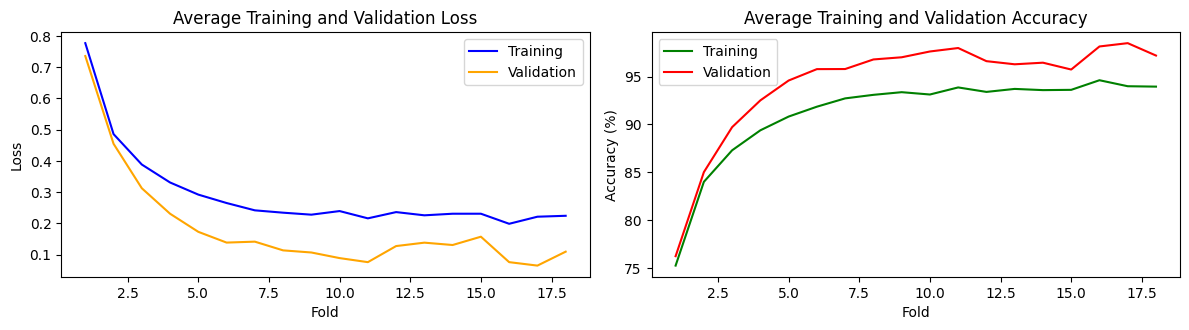

In [10]:
plt.figure(figsize=(12, 6))

# Plotting average training and validation losses
plt.subplot(2, 2, 1)
plt.plot(range(1, len(all_train_losses) + 1), all_train_losses, color='blue', label='Training')
plt.plot(range(1, len(all_val_losses) + 1), all_val_losses, color='orange', label='Validation')
plt.title('Average Training and Validation Loss')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend()

# Plotting average training and validation accuracies
plt.subplot(2, 2, 2)
plt.plot(range(1, len(all_train_accuracies) + 1), [acc * 100 for acc in all_train_accuracies], color='green', label='Training')
plt.plot(range(1, len(all_val_accuracies) + 1), [acc * 100 for acc in all_val_accuracies], color='red', label='Validation')
plt.title('Average Training and Validation Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
test_metrics = model.evaluate(images[data_test], labels[data_test])  
print("Test loss:", test_metrics[0])
print("Test accuracy:", test_metrics[1])

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step - accuracy: 0.9987 - loss: 0.0162
Test loss: 0.019307516515254974
Test accuracy: 0.9958333373069763


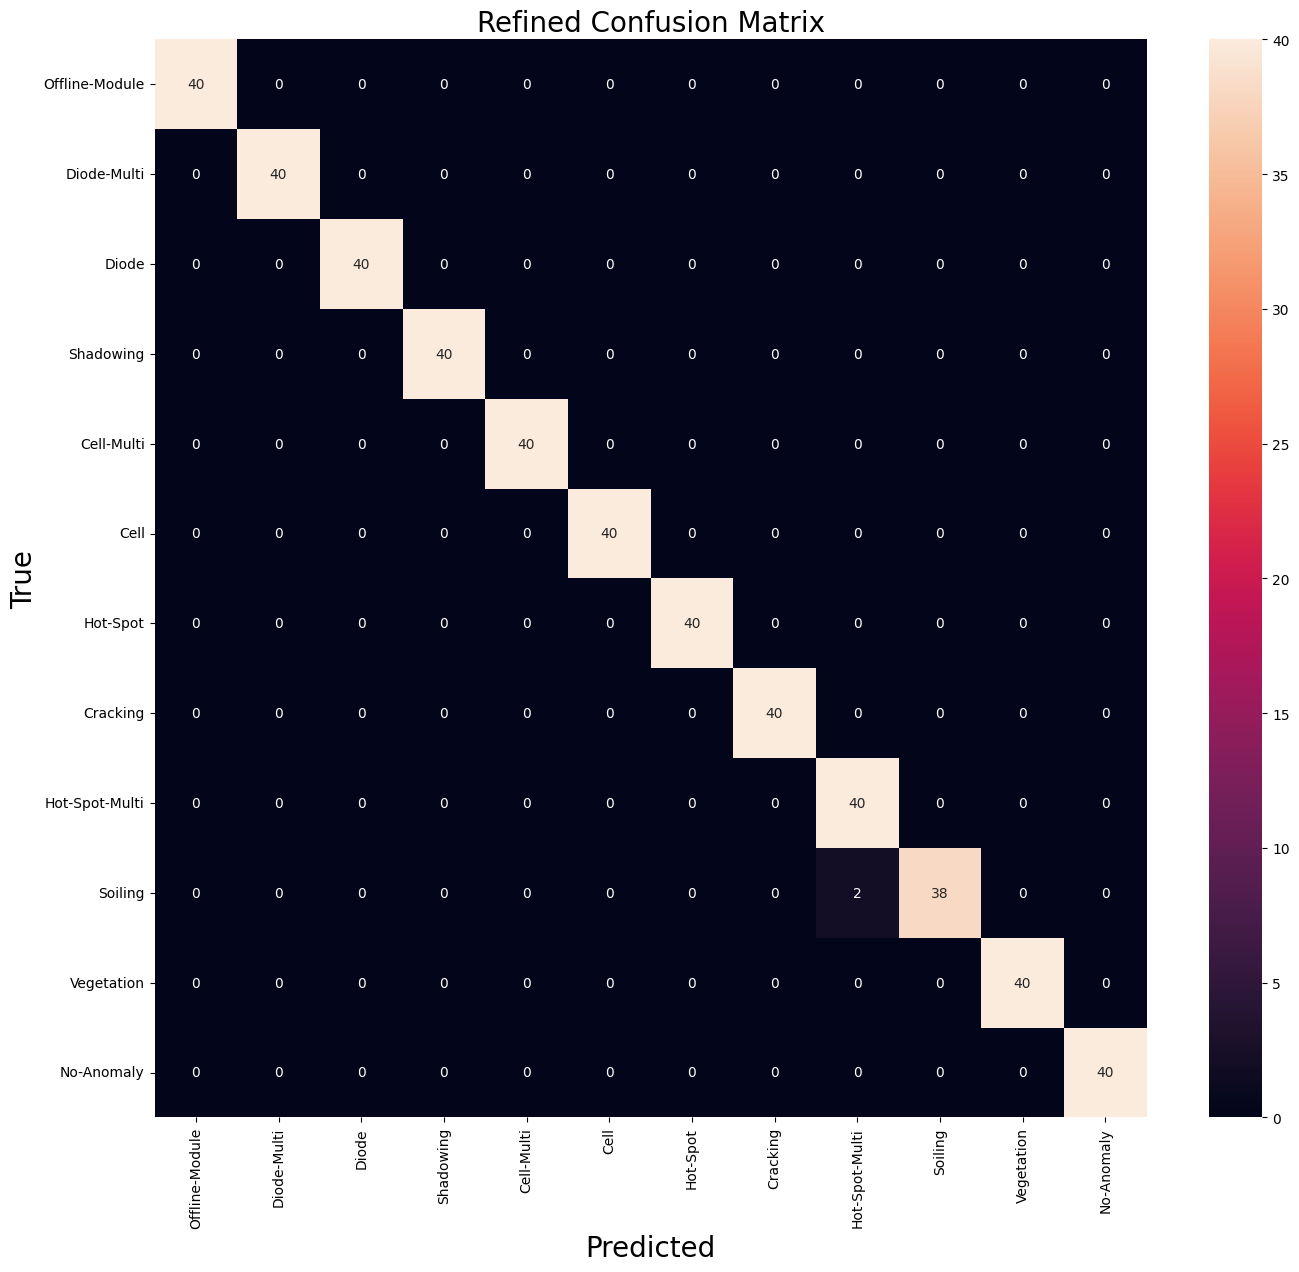

In [12]:
### Confusion Matrix
predictions = model.predict(images[data_test], steps=len(data_test), verbose=0)

y_pred = np.argmax(predictions, axis=-1)

cm = confusion_matrix(labels[data_test], y_pred)

## Get Class Labels
class_names = Classes

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True,robust=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)

plt.show()

In [13]:
tp_and_fn = cm.sum(1)
tp_and_fp = cm.sum(0)
tp = cm.diagonal()
accuracy = cm.diagonal().sum()/cm.sum()
precision = tp / tp_and_fp
recall = tp / tp_and_fn
f1 = 2 * (precision * recall) / (precision + recall)
precision_avg=np.average(precision)
recall_avg=np.average(recall)
f1_avg=np.average(f1)

In [14]:
# Creating a dictionary with the data
data = {
    'Metrics': ['Accuracy', 'Average Precision', 'Average Recall', 'Average F1 Score'],
    'Values': [accuracy, precision_avg, recall_avg, f1_avg]
}

# Creating the DataFrame
df = pd.DataFrame(data)

# Displaying the DataFrame
print(df)

             Metrics    Values
0           Accuracy  0.995833
1  Average Precision  0.996032
2     Average Recall  0.995833
3   Average F1 Score  0.995831


In [15]:
data = {
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}

# Creating the DataFrame
df = pd.DataFrame(data)

# Displaying the DataFrame
print(df)

             Class  Precision  Recall  F1 Score
0   Offline-Module   1.000000    1.00  1.000000
1      Diode-Multi   1.000000    1.00  1.000000
2            Diode   1.000000    1.00  1.000000
3        Shadowing   1.000000    1.00  1.000000
4       Cell-Multi   1.000000    1.00  1.000000
5             Cell   1.000000    1.00  1.000000
6         Hot-Spot   1.000000    1.00  1.000000
7         Cracking   1.000000    1.00  1.000000
8   Hot-Spot-Multi   0.952381    1.00  0.975610
9          Soiling   1.000000    0.95  0.974359
10      Vegetation   1.000000    1.00  1.000000
11      No-Anomaly   1.000000    1.00  1.000000
